В целом этот код сгенерил GPT.
В нем реализован метод Рунге Кутты 4 порядка, используется разностная аппроксимация для производной по координате. 
В том числе из-за плохо подходящей для данной задачи разностной аппроксимации, в решениях наблюдаются сильные расхождения.

В программе также используются формулы для перехода к размерным величинам (в системе СИ) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Начальные условия для точечного взрыва

In [ ]:
e_explosion = 1e4# Дж
r_Min = 0.1 # м
gamma = 1.4
p = e_explosion*(gamma - 1)/(4*np.pi*r_Min**3/3)
p_atm = 101325.0
print(p, p/p_atm)

954929.6585513717 9.424422981015264


параметры для сверхновых

In [ ]:
r_Min = 0.1 # м главное чтобы было много меньше расчетной области
r_Bound = 4 * r_Min # область выделения энергии: r_Min < r_Bound << 
r_Max = 1e9 
# 1e9 - 1e11(м)(несколько световых секунд) - для расчета первых секуд
# 1e15(м)(0.1 светового года) - для моделирования дней и месяцев 

N_points = 1000 # для начала (но зависит от используемых размеров r_Max и требуемой точности)

e_explosion = 1e37# Дж до 1e40...

gamma = 1.4

#p = e_explosion*(gamma - 1)/(4*np.pi*r_Min**3/3)

rho_matter = 1e-18 # кг / м^3  до 1e-22.. (зависит от околозвездного вещества)

# p = rho * R * T
R = 287 # Дж / (кг*К)
T = 100 # К от 10 до 100 в межзвездном веществе
p = T * rho_matter * R 

print(p, p/p_atm)

2.87e-14 2.832469775474957e-19


### Cферически симметричный случай

##### Преобразования в размерные/безразмерные величины

In [ ]:
gamma = 1.4 
rho0 = 1.225  # кг/м^3 (плотность воздуха на уровне моря)
p0   = 101325.0  # Па (атмосферное давление)
L0   = 1.0     # м (характерная длина)
U0   = np.sqrt(gamma * p0 / rho0) # м/с (характерная скорость, примерно скорость звука)
T0 = p0 / (rho0 * 287.0) # K (Характерная температура)
t_0   = L0 / U0    # Характерное время (с)
R = 287.0 # Газовая постоянная для воздуха (Дж/(кг*К))

def Conversion_in_Dim_quantities(x, rho, u, p, T, S, e):
    """Преобразование безразмерных величин в размерные """
    return x*L0, rho*rho0, u*U0, p*p0, T*T0, S * R, e * U0**2 # S: Дж/кг/К, e: Дж/кг

def Conversion_in_Dim_less_quantities(x, rho, u, p, T, S, e):
    """Преобразование размерных величин в безразмерные."""
    return x/L0, rho/rho0, u/U0, p/p0, T/T0, S / R, e / U0**2

def ConversionTime_in_Dim(t):
    """Преобразование безразмерного времени в размерное."""
    return t*t_0

def ConversionTime_in_Dim_less(t):
    """Преобразование размерного времени в безразмерное."""
    return t/t_0
print(rho0,p0,L0,U0,T0, t_0, sep='\n')

1.225
101325.0
1.0
340.29399054347107
288.20308611249374
0.002938635496921167


##### Функции визуализации 

In [37]:
fig_size = (10, 8)  # Увеличим размер, чтобы уместить несколько графиков
line_color = 'black'
grid_linestyle = '--'
grid_alpha = 0.5
grid_color = 'gray'

def create_subplots(r, rho, u, p, T, S, e, message : str, time):  # Добавляем S, e
    """Создает подграфики для плотности, скорости, давления, температуры и энтропии."""
    fig, axes = plt.subplots(2, 3, figsize=fig_size)  # Теперь 2x3, чтобы добавить энтропию
    fig.suptitle(f"{message}: time = {time:.5f} sec", fontsize=16)

    # Density plot
    axes[0, 0].plot(r, rho, color=line_color)
    axes[0, 0].set_xlabel('r (м)', fontsize=10)
    axes[0, 0].set_ylabel('Плотность (кг/м^3)', fontsize=10)
    axes[0, 0].set_title('Плотность', fontsize=12)
    axes[0, 0].grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)

    # Velocity plot
    axes[0, 1].plot(r, u, color=line_color)
    axes[0, 1].set_xlabel('r (м)', fontsize=10)
    axes[0, 1].set_ylabel('Скорость (м/с)', fontsize=10)
    axes[0, 1].set_title('Скорость', fontsize=12)
    axes[0, 1].grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)

    # Pressure plot
    axes[0, 2].plot(r, p, color=line_color)
    axes[0, 2].set_xlabel('r (м)', fontsize=10)
    axes[0, 2].set_ylabel('Давление (Па)', fontsize=10)
    axes[0, 2].set_title('Давление', fontsize=12)
    axes[0, 2].grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)
    
    y_ticks = np.linspace(0, np.max(p), int(np.max(p)/np.min(p)))  # 5 значений от 0 до max(p)
    y_ticks = np.arange(0, np.max(p)*1.1, np.min(p))
    axes[0, 2].set_yticks(y_ticks)
    
    # Temperature plot
    axes[1, 0].plot(r, T, color=line_color)
    axes[1, 0].set_xlabel('r (м)', fontsize=10)
    axes[1, 0].set_ylabel('Температура (K)', fontsize=10)
    axes[1, 0].set_title('Температура', fontsize=12)
    axes[1, 0].grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)

    y_ticks = np.linspace(0, np.max(T), 5)  # 7 значений от 0 до max(p)
    y_ticks = np.arange(0, np.max(T)*1.1, np.min(T))
    axes[1, 0].set_yticks(y_ticks)
    
    # Entropy plot
    axes[1, 1].plot(r, S, color=line_color)  # Добавляем график энтропии
    axes[1, 1].set_xlabel('r (м)', fontsize=10)
    axes[1, 1].set_ylabel('Энтропия (Дж/кг/К)', fontsize=10)
    axes[1, 1].set_title('Энтропия', fontsize=12)
    axes[1, 1].grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)

    # Internal energy plot
    axes[1, 2].plot(r, e, color=line_color)
    axes[1, 2].set_xlabel('r (м)', fontsize=10)
    axes[1, 2].set_ylabel('Внутренняя энергия (Дж/кг)', fontsize=10)
    axes[1, 2].set_title('Внутренняя энергия', fontsize=12)
    axes[1, 2].grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)

    y_ticks = np.linspace(0, np.max(e), 5)  # 7 значений от 0 до max(p)
    y_ticks = np.arange(0, np.max(e)*1.1, np.min(e))
    axes[1, 2].set_yticks(y_ticks)
    
    # ---------------------
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.close(fig)
    
def Visualization(r, rho, u, p, T, S, e, message : str, time):
    print(message+":")
    create_subplots(r, rho, u, p, T, S, e, message, time)

##### Основной код

0.34029399054347104 0.003402939905434711
Start:


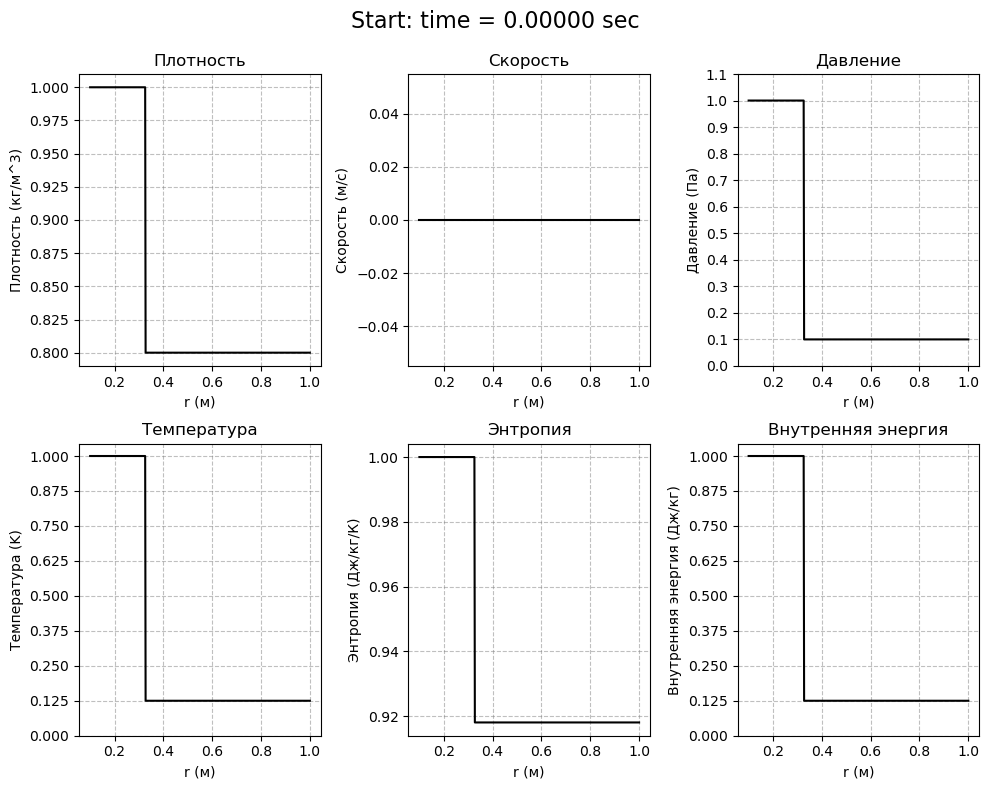

0.003402939905434711 1.0
Time: 0.000002
0.0006097305244534404 1.0640137954970936
Time: 0.000003
0.0005397336053366034 1.1082294649814404
Time: 0.000005
0.0004908726133585669 1.1383992884436707
Time: 0.000006
0.0004558736061455683 1.157874240244192
Time: 0.000007
0.0004300331732796425 1.1688194494878879
Time: 0.000009
0.00041027756320493843 1.1727906222741784
Time: 0.000010
0.0003943387723273119 1.17101984841343
Time: 0.000011
0.00038019366128865174 1.2251760257924398
Time: 0.000012
0.0003656978993721043 1.3151292096312623
Time: 0.000013
0.00034847468097641034 1.4001540412826345
Time: 0.000014
0.0003262480473071747 1.4739628833574123
Time: 0.000015
0.00029770029725386256 1.531651115920613
Time: 0.000016
0.0002633570859734939 1.571282668386009
Time: 0.000016
0.00022551911183907246 1.594292283253141
Time: 0.000017
0.00018702287226932335 1.6044131638336827
Time: 0.000017
0.0001499169528107149 1.6060658750849124
Time: 0.000018
0.00011496603222420574 1.6032148850921089
Time: 0.000018
8.17461

C:\Users\izavo\AppData\Local\Temp\ipykernel_21636\3048569766.py:6: RuntimeWarning: invalid value encountered in log
  S = e/T + R*np.log(rho) # Удельная энтропия (Дж/(кг*К))
C:\Users\izavo\AppData\Local\Temp\ipykernel_21636\3048569766.py:180: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(gamma * p / rho)  # скорость звука
C:\Users\izavo\AppData\Local\Temp\ipykernel_21636\3048569766.py:135: RuntimeWarning: overflow encountered in square
  p = (gamma - 1)*(E - 0.5*rho*u**2)
C:\Users\izavo\AppData\Local\Temp\ipykernel_21636\3048569766.py:6: RuntimeWarning: invalid value encountered in divide
  S = e/T + R*np.log(rho) # Удельная энтропия (Дж/(кг*К))
C:\Users\izavo\AppData\Local\Temp\ipykernel_21636\3048569766.py:52: RuntimeWarning: overflow encountered in square
  E = p / (gamma - 1) + 0.5 * rho * u**2
C:\Users\izavo\AppData\Local\Temp\ipykernel_21636\3048569766.py:52: RuntimeWarning: invalid value encountered in add
  E = p / (gamma - 1) + 0.5 * rho * u**2
C:\Users\izavo

Time: 0.000041
4.835674521110784e-05 nan
Time: 0.000041
4.835674521110784e-05 nan
Time: 0.000041
4.835674521110784e-05 nan
Time: 0.000042
4.835674521110784e-05 nan
Time: 0.000042
4.835674521110784e-05 nan
Time: 0.000042
4.835674521110784e-05 nan
Time: 0.000042
4.835674521110784e-05 nan
Time: 0.000042
4.835674521110784e-05 nan
Time: 0.000042
4.835674521110784e-05 nan
Time: 0.000042
4.835674521110784e-05 nan
Time: 0.000043
4.835674521110784e-05 nan
Time: 0.000043
4.835674521110784e-05 nan
Time: 0.000043
4.835674521110784e-05 nan
Time: 0.000043
4.835674521110784e-05 nan
Time: 0.000043
4.835674521110784e-05 nan
Time: 0.000043
4.835674521110784e-05 nan
Time: 0.000043
4.835674521110784e-05 nan
Time: 0.000044
4.835674521110784e-05 nan
Time: 0.000044
4.835674521110784e-05 nan
Time: 0.000044
4.835674521110784e-05 nan
Time: 0.000044
4.835674521110784e-05 nan
Time: 0.000044
4.835674521110784e-05 nan
Time: 0.000044
4.835674521110784e-05 nan
Time: 0.000044
4.835674521110784e-05 nan
Time: 0.000045
4

ValueError: cannot convert float NaN to integer

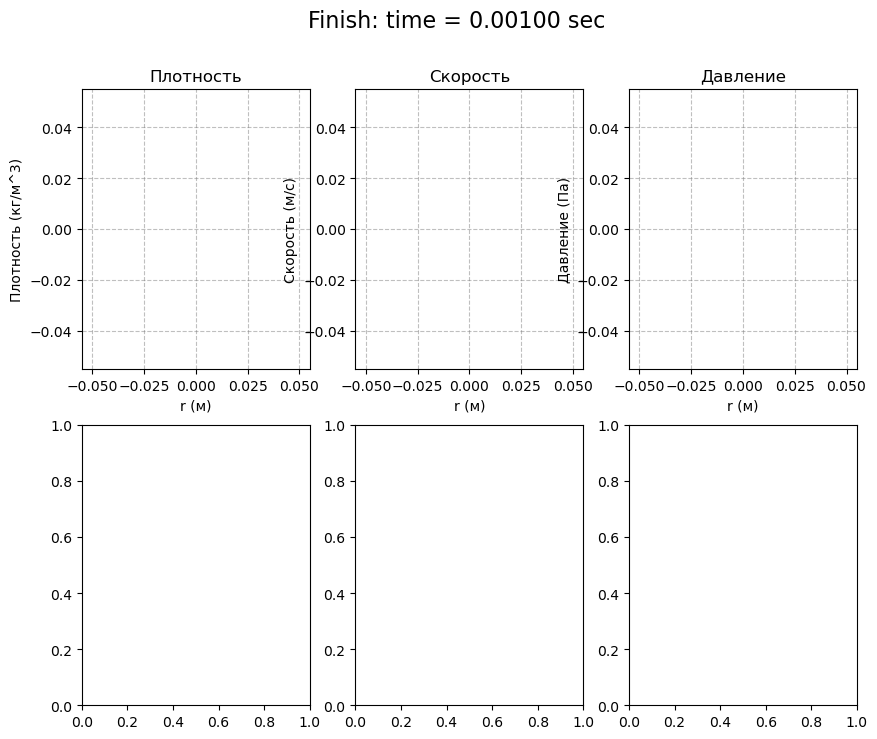

In [46]:

def calculate_temperature_and_entropy(rho, p, gamma):
    """Вычисляет температуру, удельную энтропию и удельную внутреннюю энергию."""
    R = 287.0  # Газовая постоянная для воздуха (Дж/(кг*К))
    e = p / ((gamma - 1) * rho)  # Удельная внутренняя энергия
    T = p / (rho * R)  # Уравнение состояния для идеального газа
    S = e/T + R*np.log(rho) # Удельная энтропия (Дж/(кг*К))
    return T, S, e

def Initial_Conditional(r : list, n_points : int):
    """Установка начальных параметров."""
    #rho_0 = 1.225 # кг/м^3
    p_0 = 101325.0 # Па (атмосфера)
    R = 287.0
    V_center = 0.8 # (4/3) * np.pi * r[0]**3 # удельный объём центральной части
    rho_center = 1 / V_center
    e_center = 202650 # Дж/кг - удельная внутренняя энергия  
    p_center = (e_center * (gamma - 1) / V_center) # Получили в безразмерных (кол-во атмосфер)
    r_bound = r[int(n_points / 4)]
    T_center = e_center * (gamma - 1) / R
    S_center = e_center/T_center + R*np.log(rho_center)
    
    rho = np.ones(n_points)
    u = np.zeros(n_points)
    p = np.ones(n_points)
    p[r <= r_bound] = p_center
    p[r > r_bound] = p_center / 10
    rho[r <= r_bound] = rho_center
    
    T = np.ones(n_points)
    S = np.ones(n_points)
    e = np.ones(n_points)
    
    T, S, e = calculate_temperature_and_entropy(rho, p, gamma)
    
    rho[:] = rho[:] / rho_center
    p[:] = p[:] / p_center
    T[:] = T[:] / T_center
    e[:] = e[:] / e_center
    S[:] = S[:] / S_center
    
    return rho, u, p, T, S, e

def calculate_fluxes(rho, u, p, gamma, r): 
    """Подсчет потоков массы, импульса и энергии по простым формулам, без пересчета по усредненным."""
    F_rho  = rho * u
    F_rhou = rho * u**2 + p
    F_rhoE    = (0.5*rho*u**2 + p/(gamma - 1))*u*rho
    return F_rho, F_rhou, F_rhoE

# --------------------- Функция обновления переменных (RK4) 
def rk4_step(rho, u, p, r, dr, dt, gamma):
    E = p / (gamma - 1) + 0.5 * rho * u**2
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho, u, p, gamma, r) 


    # Функция для расчета r^2 * flux в узлах сетки
    def r_squared_flux(r, flux):
        return r**2 * flux

    # k1
    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    #Вычисляем производную используя центральную разность
    drho_dt1  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2
    drhou_dt1 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2 + 2*p/r 
    dE_dt1    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2 

    k1_rho  = dt * drho_dt1
    k1_rhou = dt * drhou_dt1
    k1_E    = dt * dE_dt1

    # k2
    rho_temp = rho + k1_rho / 2
    u_temp   = u + k1_rhou / (2*rho) / 2
    E_temp = E + k1_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma, r) 

    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    drho_dt2  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2 
    drhou_dt2 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2  + 2*p_temp/r#Добавляем /r**2  + 2p/r
    dE_dt2    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2

    k2_rho  = dt * drho_dt2
    k2_rhou = dt * drhou_dt2
    k2_E    = dt * dE_dt2

    # k3
    rho_temp = rho + k2_rho / 2
    u_temp   = u + k2_rhou / (2*rho) / 2
    E_temp = E + k2_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma, r)

    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    drho_dt3  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2 
    drhou_dt3 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2  + 2*p_temp/r
    dE_dt3    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2

    k3_rho  = dt * drho_dt3
    k3_rhou = dt * drhou_dt3
    k3_E    = dt * dE_dt3

    # k4
    rho_temp = rho + k3_rho
    u_temp   = u + k3_rhou / (2*rho)
    E_temp = E + k3_E
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma,r)

    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    drho_dt4  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2
    drhou_dt4 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2 + 2*p_temp/r 
    dE_dt4    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2

    k4_rho  = dt * drho_dt4
    k4_rhou = dt * drhou_dt4
    k4_E    = dt * dE_dt4

    # Обновление переменных
    rho = rho + (k1_rho + 2*k2_rho + 2*k3_rho + k4_rho) / 6
    u   = u   + (k1_rhou + 2*k2_rhou + 2*k3_rhou + k4_rhou) / 6
    E   = E   + (k1_E + 2*k2_E + 2*k3_E + k4_E) / 6
    p = (gamma - 1)*(E - 0.5*rho*u**2)
    
    rho[0] = rho[1]
    u[0] = -u[1]  # Отражаем скорость (симметрия)
    p[0] = p[1]

    rho[-1] = rho[-2] + (rho[-2] - rho[-3])
    u[-1] = u[-2] + (u[-2] - u[-3])
    p[-1] = p[-2] + (p[-2] - p[-3])
    
    T, S, e = calculate_temperature_and_entropy(rho, p, gamma)
    return rho, u, p, T, S, e

# ----------- Инициализация сетки -----------------
# ---------- (сферическая геометрия) --------------

n_points = 500 # Количество точек
r_min = 0.1    # Мин радиус (м)
r_max = 1.0    # Макс радиус (м)
r = np.linspace(r_min, r_max, n_points)  # Радиальная координата
dr = r[1] - r[0]  # Шаг по радиусу

# -----------  Инициализация переменных -----------

gamma = 1.4 # Показатель адиабаты
rho, u, p, T, S, e = Initial_Conditional(r, n_points) 

#r, rho, u, p, T, S, e = Conversion_in_Dim_less_quantities(r, rho, u, p, T, S, e)
#print(max(p))

# ----------- Временные параметры -----------

t      = 0.0
t_end_dim  = 0.001#  В секундах
cfl    = 0.4     # CFL number (adjust as needed)
dt_dim     = 1.0e-5 # Initial time step (adjust as needed)
t_end, dt = ConversionTime_in_Dim_less(np.array([t_end_dim, dt_dim]))
print(t_end, dt)

Visualization(r, rho, u, p, T, S, e, 'Start', t)

#  ----------- Основной цикл времени -----------

while t < t_end:
    # Ограничение шага по времени (теперь с размерной скоростью звука)
    a = np.sqrt(gamma * p / rho)  # скорость звука
    #print(dt,cfl,dr,a,np.max(np.abs(u) + a))
    print(dt, np.max(rho))
    dt = min(dt, cfl * dr / np.max(np.abs(u) + a))  # Шаг по времени
    #, max(p), max(a*U0))
    
    rho, u, p, T, S, e = rk4_step(rho, u, p, r, dr, dt, gamma)  # Передаем r и dr
    t += dt
    print(f"Time: {ConversionTime_in_Dim(t):.6f}")
    #flag = int(input())
    #if flag == 0:
    #    break

# ------------ Переход к размерным величинам ----------

r, rho, u, p, T, S, e = Conversion_in_Dim_quantities(r, rho, u, p, T, S, e)

# ------------ Построение графиков --------------

Visualization(r, rho, u, p, T, S, e, 'Finish', ConversionTime_in_Dim(t))

    

##### Некоторые тесты сферически симметричного случая

1) Начальное условие: возмущение в плотности, должна быть скорость звука
ρ(r, 0) = ρ₀ + A * exp(-(r - r₀)² / σ²) (ρ₀ - средняя плотность, A - амплитуда возмущения, r₀ - положение центра возмущения, σ - ширина возмущения)
u(r, 0) = 0
p(r, 0) = p₀ (постоянное давление)

2) Начальное условие: точечный взрыв